##### Project 2 - Big-Scale Analytics 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [3]:
# A disaster tweet
disaster_tweet = train[train['target'] == 1]['text']
disaster_tweet.values[1]

'TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/TWPl0NL8cx'

In [4]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['target'] == 0]['text']
non_disaster_tweet.values[1]

'RT RoadID: Thanks to Alex for his story &amp; to all first responders for being there when we need you. \x89Û_ http://t.co/HikDC1fM2F'

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Libraries and EDA

Before starting the classification problems, let's first explore the dataset. 
During this exploratory analysis, we will observe the distribution of data according the differents variables available on the tweets: Target, Keyword, Location and Text. It permits to understand better the composition of the dataset, and the tweets we'll have to classify.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

### Distribution of 'Target' column
This binary variable, like explained earlier, permits to identify the tweets mentionning a disaster from a tweet mentionning something else.
The following code permit to know the number of tweets in the train dataset, and to identify the repartition of disaster tweets.

In [6]:
total_count = 0
for row in train.iterrows():
  total_count += 1
print(f'There are {total_count} tweets in the dataset')

train_yes = train.query('target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters')

train_no = train.query('target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters')

print('The classification base rate is ' + str(yes_count/(yes_count+no_count)*100)[:5] + '%')

There are 7613 tweets in the dataset
There are 3271 tweets about disasters
There are 4342 tweets that are not about disasters
The classification base rate is 42.96%


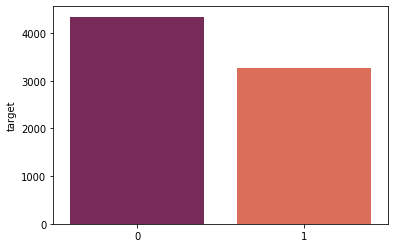

In [9]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts(), palette = 'rocket')

Text(0, 0.5, 'Samples')

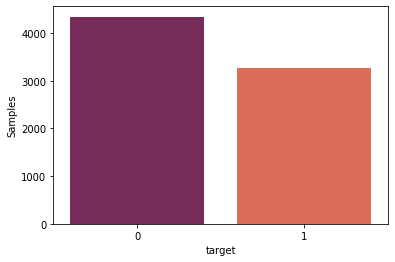

In [15]:
sns.countplot('target',data = train, palette = 'rocket')
plt.gca().set_ylabel('Samples')

### Distribution of 'Keyword' column

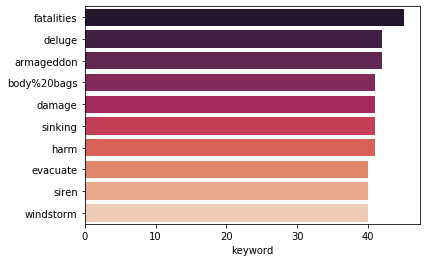

In [10]:
sns.barplot(y = train['keyword'].value_counts()[:10].index, x = train['keyword'].value_counts()[:10], orient='h', palette = 'rocket')

### Most common locations

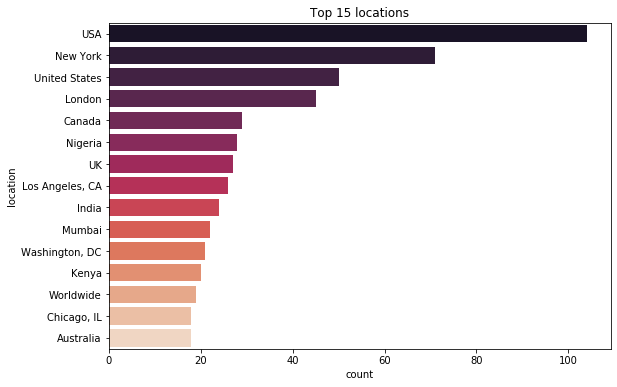

In [18]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index, palette = 'rocket')
plt.title('Top 15 locations')
plt.show()

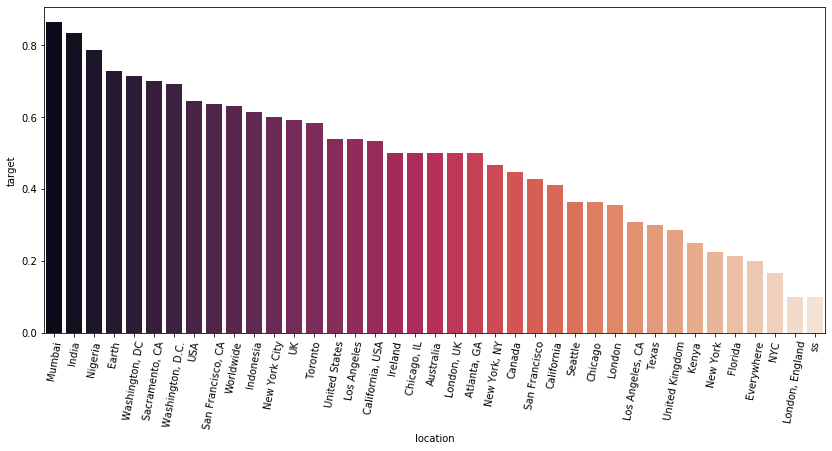

In [24]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l, palette = 'rocket')
plt.xticks(rotation=80)
plt.show()

### Distribution of Character, Word and Sentence Frequency

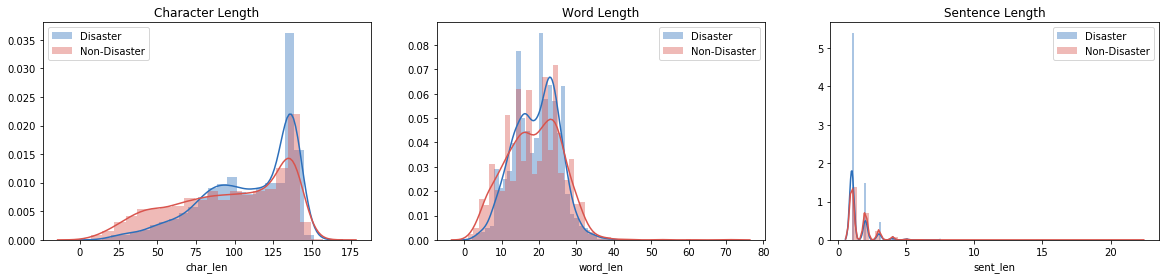

In [36]:
# count number of characters in each tweet
train['char_len'] = train.text.str.len()

# count number of words in each tweet
word_tokens = [len(word_tokenize(tweet)) for tweet in train.text]
train['word_len'] = word_tokens

# count number of sentence in each tweet
sent_tokens = [len(sent_tokenize(tweet)) for tweet in train.text]
train['sent_len'] = sent_tokens

plot_cols = ['char_len','word_len','sent_len']
plot_titles = ['Character Length','Word Length','Sentence Length']

plt.figure(figsize=(20,4))
for counter, i in enumerate([0,1,2]):
    plt.subplot(1,3,counter+1)
    sns.distplot(train[train.target == 1][plot_cols[i]], label='Disaster', color=color[1]).set_title(plot_titles[i])
    sns.distplot(train[train.target == 0][plot_cols[i]], label='Non-Disaster', color=color[0])
    plt.legend()

### Most common stopwords

Text(0.5, 1.0, 'Top Stopwords for  Non-Disaster Tweets')

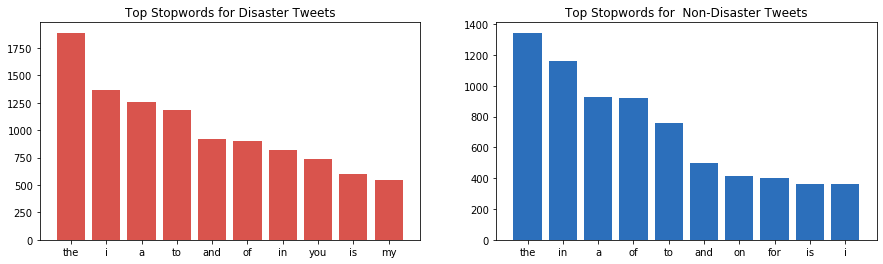

In [41]:
## Plot most common stopwords

stop = set(stopwords.words('english'))

# Get all the word tokens in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in train[train.target == 0].text for word in word_tokenize(tweet)]
corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in train[train.target == 1].text for word in word_tokenize(tweet)]

# Function for counting top stopwords in a corpus
def count_top_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop: 
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:10] # get the top 10 stopwords
    x,y = zip(*topwords) # get key and values
    return x,y

x0,y0 = count_top_stopwords(corpus0)
x1,y1 = count_top_stopwords(corpus1)

# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=color[0])
plt.title('Top Stopwords for Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=color[1])
plt.title('Top Stopwords for  Non-Disaster Tweets')

### Most common punctuations

Text(0.5, 1.0, 'Top Punctuations for Non-Disaster Tweets')

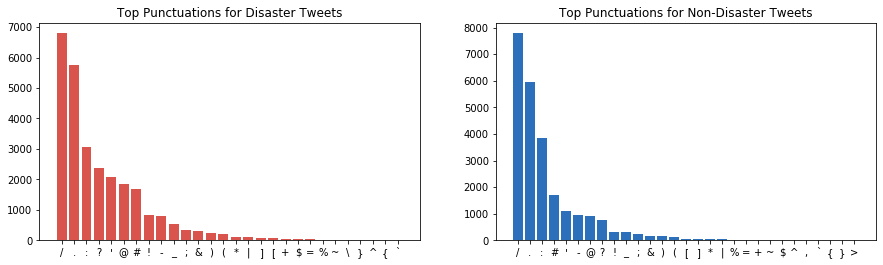

In [42]:
## Plot most common punctuations

from string import punctuation

# Get all the punctuations in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(c) for tweet in train[train.target == 0].text for c in tweet]
corpus0 = list(filter(lambda x: x in punctuation, corpus0)) # use filter to select only punctuations
corpus1 = [] # Disaster
[corpus1.append(c) for tweet in train[train.target == 1].text for c in tweet]
corpus1 = list(filter(lambda x: x in punctuation, corpus1)) 

from collections import Counter
x0,y0 = zip(*Counter(corpus0).most_common())
x1,y1 = zip(*Counter(corpus1).most_common())

# Plot bar plot of top punctuations for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color=color[0])
plt.title('Top Punctuations for Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color=color[1])
plt.title('Top Punctuations for Non-Disaster Tweets')

### Most common words

In [ ]:
## Plot most common words
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop = ENGLISH_STOP_WORDS.union(stop) # combine stop words from different sources

# function for removing url from text
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Get all the word tokens in dataframe for Disaster and Non-Disaster
# - remove url, tokenize tweet into words, lowercase words
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in df[df.target == 0].text for word in word_tokenize(remove_url(tweet))]
corpus0 = list(filter(lambda x: x not in stop, corpus0)) # use filter to unselect stopwords

corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in df[df.target == 1].text for word in word_tokenize(remove_url(tweet))]
corpus1 = list(filter(lambda x: x not in stop, corpus1)) # use filter to unselect stopwords

# Create df for word counts to use sns plots
a = Counter(corpus0).most_common()
df0 = pd.DataFrame(a, columns=['Word','Count'])

a = Counter(corpus1).most_common()
df1 = pd.DataFrame(a, columns=['Word','Count'])

# Plot for Disaster and Non-Disaster
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='Word',y='Count',data=df0.head(10)).set_title('Most Common Words for Non-Disasters')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x='Word',y='Count',data=df1.head(10)).set_title('Most Common Words for Disasters')
plt.xticks(rotation=45)

### Word cloud

In [ ]:
#!pip install wordcloud
def clean(word):
    for p in punctuation: word = word.replace(p, '')
    return word

from wordcloud import WordCloud

def wc_hash(target):
    hashtag = [clean(w[1:].lower()) for tweet in df[df.target == target].text for w in tweet.split() if '#' in w and w[0] == '#']
    hashtag = ' '.join(hashtag)
    my_cloud = WordCloud(background_color='white', stopwords=stop).generate(hashtag)

    plt.subplot(1,2,target+1)
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")

plt.figure(figsize=(15,4))
wc_hash(0)
plt.title('Non-Disaster')
wc_hash(1)
plt.title('Disaster')

# III. Data processing

## 1. Import libraries and load data

In [ ]:
import pandas as pd
import string
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk

parser = English()
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation


In [ ]:
#!pip install spacy
#!python -m spacy download en

In [ ]:
train = pd.read_csv ('../data/train.csv')
train = train[['id', 'text', 'target']]

test = pd.read_csv ('../data/test.csv')
test = test[['id', 'text']]

train.head()

## 2. Text processing

### Lowercase and remove punctuation

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
  
  
train['filtered_tweet'] = train['text'].apply(lambda x: clean_text(x))
test['filtered_tweet'] = test['text'].apply(lambda x: clean_text(x))

train.head()

### Tokenize tweets

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

train.head()

### Remove stopwords and punctuation

In [ ]:
# remove stopwords and punctuation
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords.words('english')]
    text = [word for word in text if word not in punctuations]
    
    return text

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: remove_stopwords(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: remove_stopwords(x))

train.head()

### Recreate sentences

In [ ]:
def sentence(text):
  sentence = ''
  for word in text:
    sentence = sentence + ' ' + word
  
  return sentence

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: sentence(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: sentence(x))

train.head()

# IV. Classification models

## Create pipe

In [ ]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() 
                if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens 
                if word not in stop_words and word not in punctuations ]

    return mytokens


X = train['filtered_tweet']
y = train['target']

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

## 1. KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

classifier = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

### Plot for different values of n

In [ ]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 500, 1):
    classifier = KNeighborsClassifier(n_neighbors = i, weights = 'distance')

    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[i] = accuracy
    data_prec[i] = precision
    data_rec[i] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of n')

In [ ]:
print('optimal number of neighbors: ', np.argmax(values_acc))

classifier = KNeighborsClassifier(n_neighbors = np.argmax(values_acc), weights = 'distance')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

### Plot for different values of train/test split treshold

In [ ]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
    
    classifier = KNeighborsClassifier(n_neighbors = 64, weights = 'distance')

    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [ ]:
print('optimal treshold: ', np.argmax(values_acc))

In [ ]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = KNeighborsClassifier(n_neighbors = 64, weights = 'distance')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

### Run on test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_KNN.csv',index=False)

## 2. Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

classifier = MultinomialNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

### Plot for different values of train/test split treshold

In [ ]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)

    classifier = MultinomialNB()
    
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [ ]:
print('optimal treshold: ', np.argmax(values_acc))

In [ ]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2, which seems also to be an optimum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = MultinomialNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

### Run on test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']



pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_MNB.csv',index=False)

## 3. Bernouilli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

classifier = BernoulliNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

### Plot for different values of train/test split treshold

In [ ]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)

    classifier = BernoulliNB()
    
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [ ]:
print('optimal treshold: ', np.argmax(values_acc))

In [ ]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2, which seems also to be an optimum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = BernoulliNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

### Run on test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_BNB.csv',index=False)

## 4. Logistic regression

In [ ]:
#!python -m spacy download en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

classifier = LogisticRegression(solver="lbfgs")

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

In [ ]:
print(f'For a train/test split treshold of 0.3: \n')

print(f'We can see here that our model identified a tweet about a disaster {str(accuracy*100)[:4]}% of the time. \n')

print(f'When it predicted a tweet to be about a disaster, it was correctly assessed {str(precision[0]*100)[:4]}% of the time, \nand was correctly assessed for a tweet not about a disaster {str(precision[1]*100)[:4]}% of the time. \n')

print(f'When given a tweet about a disaster, the model considered it as being about a disaster {str(recall[0]*100)[:4]}% of the time, \nand when given a tweet not about a disaster the model considered it as not a disaster for {str(recall[1]*100)[:4]}% of the time. \n')

### Plot the results for different levels of train/test split treshold

In [ ]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [ ]:
print('From those graphs, we can see that the optimal train/test split treshold is: ', np.argmax(values_acc))

### Test the model on the testing dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_LR.csv',index=False)

## 5. Neural networks

### Vectorizing tweets

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X_train = train['filtered_tweet']
y_train = train['target']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

word_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", 
                stop_words=None, ngram_range=(2,2), analyzer='word')

# Vectorize the training set
X_train = word_vectorizer.fit_transform(X_train.map(lambda words: ', '.join(words)))

# Vectorize the testing test
#X_test = word_vectorizer.transform(X_test.map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is a disaster tweet
#y_train = train['target']


print('train input shape: ', X_train.shape)
#print('train output shape: ', y_train.shape)
#print('test output shape: ', X_test.shape)

### Building the model

In [ ]:
#!pip install -U protobuf==3.8.0

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
#!pip install keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

In [ ]:
model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))# Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

### Train the model

In [ ]:
model_hist = model.fit(X_train, y_train,
                       batch_size=100, epochs=30,
                       verbose=1, validation_split=0.2)

### Evaluate performance

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

axs[0].plot(model_hist.history['val_accuracy'], label='validation accuracy')
axs[0].legend()

axs[1].plot(model_hist.history['accuracy'], label='accuracy')
axs[1].legend()

fig.suptitle('Validation accuracy and accuracy evolving with epochs')

### Predict for test dataset

In [ ]:
X_test = test['filtered_tweet']
X_test = word_vectorizer.transform(X_test.map(lambda words: ', '.join(words)))

y_test = model.predict_classes(X_test)

test['prediction'] = y_test

test[['text', 'prediction']].head()

In [ ]:
ysample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_NN.csv',index=False)

## 6. Decision trees

### Split train/test

In [ ]:
X = train['filtered_tweet']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

### Vectorizing tweets

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", 
                stop_words=None, ngram_range=(2,2), analyzer='word')

# Vectorize the training set
X_train = word_vectorizer.fit_transform(X_train.map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(X_test.map(lambda words: ', '.join(words)))


print('train input shape: ', X_train.shape)
print('train output shape: ', y_train.shape)
print('test output shape: ', X_test.shape)

### Fit the model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)

classifier.score(X_test,y_test)

In [ ]:
classifier.get_depth()

In [ ]:
scores = []
for d in range(1, 21):
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    
    
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

In [ ]:
print('The optimal depth is: ', np.argmax(scores))

### Evaluate model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classifier = DecisionTreeClassifier(criterion='entropy', max_depth=np.argmax(scores))
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

### Run on test dataset

In [ ]:
X_test = word_vectorizer.transform(test['filtered_tweet'].map(lambda words: ', '.join(words)))

y_test = classifier.predict(X_test)

test['prediction'] = y_test

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_DT.csv',index=False)